   EmployeeID  Education  JoiningYear       City  Country         Region  \
0           1  Bachelors         2017    Toronto   Canada  North America   
1           2  Bachelors         2013       Pune    India           Asia   
2           3  Bachelors         2014  New Delhi    India           Asia   
3           4    Masters         2016  Vancouver   Canada  North America   
4           5    Masters         2017     Berlin  Germany         Europe   

   PaymentTier  Age  Gender  ExperienceInCurrentDomain  Performance  \
0            3   34    Male                          0    74.967142   
1            1   28  Female                          3    68.617357   
2            3   38  Female                          2    76.476885   
3            3   27    Male                          5    85.230299   
4            3   24    Male                          2    67.658466   

   TeamEngagement  Collaboration  Flexibility  
0       70.745354       5.381270    21.767078  
1       69.426643   

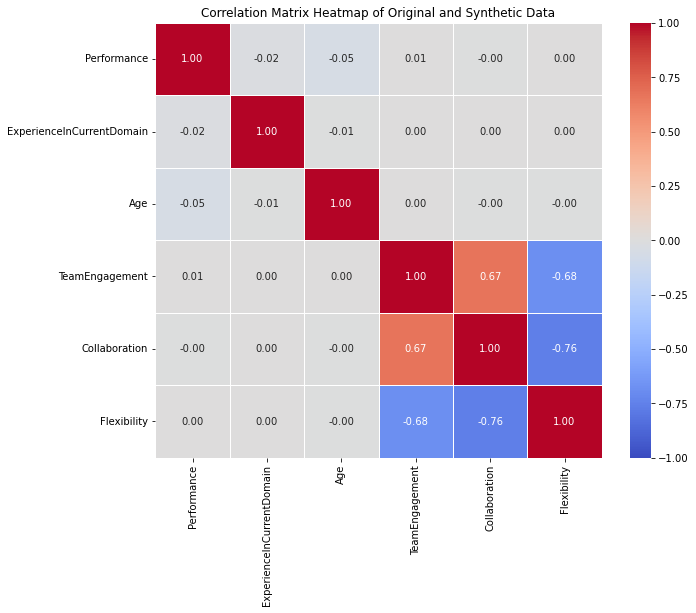

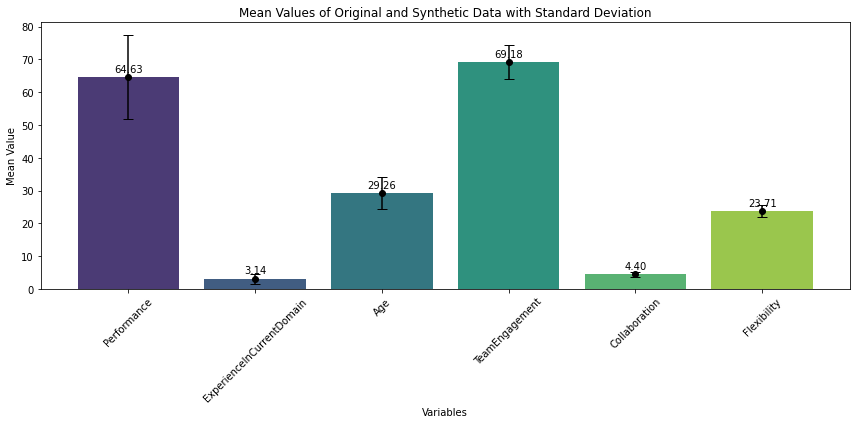

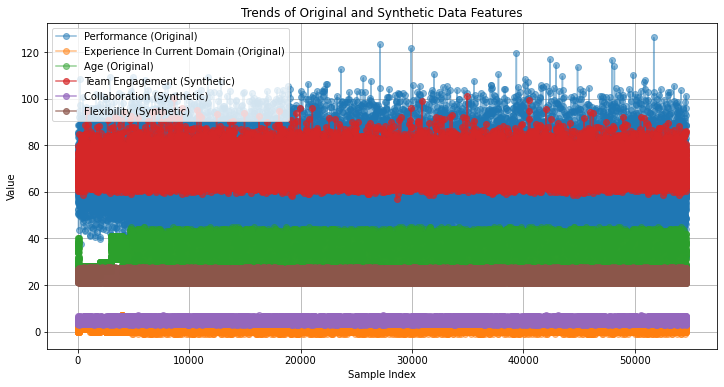

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Load the newly uploaded data file
new_file_path = 'Combined_Employee_Data_CTGAN.csv'
new_df = pd.read_csv(new_file_path)

# Define the GAN components for the new data
class NewGenerator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NewGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class NewDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(NewDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters for the new data
input_dim = 3  # Number of features (team engagement, collaboration, flexibility)
z_dim = 10     # Noise dimension
batch_size = 64
num_epochs = 10  # Reduced epochs for quicker execution
learning_rate = 0.0002

# Initialize models
generator = NewGenerator(z_dim, input_dim)
discriminator = NewDiscriminator(input_dim)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
criterion = nn.BCELoss()

# Scaling the data
scaler = MinMaxScaler()

# Prepare the real data samples
real_data_samples = scaler.fit_transform(new_df[['Performance', 'ExperienceInCurrentDomain', 'Age']].values)

# Convert real data to tensor
real_data_samples = torch.tensor(real_data_samples, dtype=torch.float32)

# Training loop (reduced for demonstration)
for epoch in range(num_epochs):
    for _ in range(len(real_data_samples) // batch_size):
        # Generate fake data
        z = torch.randn(batch_size, z_dim)
        fake_data = generator(z)

        # Get a batch of real data
        real_data = real_data_samples[np.random.randint(0, len(real_data_samples), batch_size)]

        # Discriminator loss
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        real_loss = criterion(discriminator(real_data), real_labels)
        fake_loss = criterion(discriminator(fake_data.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Generator loss
        g_loss = criterion(discriminator(fake_data), real_labels)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

# Generate synthetic data for the new dataset size
z = torch.randn(len(new_df), z_dim)
synthetic_data = generator(z).detach().numpy()

# Rescale the synthetic data back to original range
synthetic_data = scaler.inverse_transform(synthetic_data)
synthetic_df = pd.DataFrame(synthetic_data, columns=['TeamEngagement', 'Collaboration', 'Flexibility'])

# Add the synthetic data to the original dataframe
combined_df = pd.concat([new_df, synthetic_df], axis=1)

# Save the updated DataFrame to a new CSV file
new_output_file_path = 'Combined_Employee_Data_with_Synthetic_Features_2.csv'
combined_df.to_csv(new_output_file_path, index=False)

# Display the first few rows of the updated dataframe
print(combined_df.head())

# Plotting

# 1. Heatmap
corr_matrix = combined_df[['Performance', 'ExperienceInCurrentDomain', 'Age', 'TeamEngagement', 'Collaboration', 'Flexibility']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap of Original and Synthetic Data')
plt.show()

# 2. Bar Graph
mean_values = combined_df[['Performance', 'ExperienceInCurrentDomain', 'Age', 'TeamEngagement', 'Collaboration', 'Flexibility']].mean()
std_values = combined_df[['Performance', 'ExperienceInCurrentDomain', 'Age', 'TeamEngagement', 'Collaboration', 'Flexibility']].std()
plot_df = pd.DataFrame({
    'Variable': mean_values.index,
    'Mean': mean_values.values,
    'Standard Deviation': std_values.values
})

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Variable', y='Mean', data=plot_df, palette='viridis', ci=None)
for index, value in enumerate(plot_df['Mean']):
    plt.errorbar(index, value, yerr=plot_df['Standard Deviation'][index], fmt='o', color='black', capsize=5)
for index, value in enumerate(plot_df['Mean']):
    plt.text(index, value + 1, f'{value:.2f}', ha='center', va='bottom')
plt.title('Mean Values of Original and Synthetic Data with Standard Deviation')
plt.xlabel('Variables')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Line Graph
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Performance'], label='Performance (Original)', marker='o', alpha=0.5)
plt.plot(combined_df.index, combined_df['ExperienceInCurrentDomain'], label='Experience In Current Domain (Original)', marker='o', alpha=0.5)
plt.plot(combined_df.index, combined_df['Age'], label='Age (Original)', marker='o', alpha=0.5)
plt.plot(combined_df.index, combined_df['TeamEngagement'], label='Team Engagement (Synthetic)', marker='o', alpha=0.7)
plt.plot(combined_df.index, combined_df['Collaboration'], label='Collaboration (Synthetic)', marker='o', alpha=0.7)
plt.plot(combined_df.index, combined_df['Flexibility'], label='Flexibility (Synthetic)', marker='o', alpha=0.7)
plt.title('Trends of Original and Synthetic Data Features')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
